In [2]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, auc


In [3]:
# Define functions here

def visualize_bipartite_graph(G, d_nodes, t_nodes):
    pos = {}
    pos.update((node, (1, index)) for index, node in enumerate(d_nodes))  # positions for d nodes
    pos.update((node, (2, index)) for index, node in enumerate(t_nodes))  # positions for t nodes

    # Draw nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=['skyblue' if node in d_nodes else 'lightgreen' for node in G.nodes()])
    plt.title("Bipartite Graph Visualization")
    plt.show()

def preferential_attachment(d_node,t_node):
    d_degree = G.degree(d_node)
    t_degree = G.degree(t_node)

    pa = d_degree * t_degree
    return pa

def common_neighbor_jaccard_coef(G, d_node, t_node):
    # Get the neighbors of d_node and t_node
    d_neighbors = set(G.neighbors(d_node))
    t_neighbors = set(G.neighbors(t_node))

    # Get the extended neighbors of the d_neighbors and the t_neighbors
    d_neighbors_2 = set()
    for neighbor in d_neighbors:
        d_neighbors_2.update(G.neighbors(neighbor)) 
        
    t_neighbors_2 = set()
    for neighbor in t_neighbors:
        t_neighbors_2.update(G.neighbors(neighbor))
    
    # print("Second-degree neighbors from d_node:", d_neighbors_2)
    # print("Second-degree neighbors from t_node:", t_neighbors_2)
    
    # Find the common neighbors, using definition from New J Phys 17 (2015) 113037, where it's the number of nodes in the quadrangles between two seed nodes
    common_neighbors_d = d_neighbors_2 & t_neighbors
    # print('Common_neighbors_d:', common_neighbors_d)
    common_neighbor_count_d = len(common_neighbors_d)
    # print(common_neighbor_count_d)
    common_neighbors_t = t_neighbors_2 & d_neighbors
    # print('Common_neighbors_t:', common_neighbors_t)
    common_neighbor_count_t = len(common_neighbors_t)
    # print(common_neighbor_count_t)

    # assert common_neighbor_count_d == common_neighbor_count_t
    # Add up nodes from common_neighbors from d partite, and from t partite
    sum_common_neighbors_d_t = len(common_neighbors_d|common_neighbors_t)
    total_neighbors = len(d_neighbors|t_neighbors)

    # Calculate jaccard coefficient by deviding by the total amount of neighbors from d_node & t_node
    jaccard_coefficient_d_t = sum_common_neighbors_d_t / total_neighbors
    # print('Total neighbors:', total_neighbors)
    print('Jaccard_coefficient:', jaccard_coefficient_d_t)
    return sum_common_neighbors_d_t, jaccard_coefficient_d_t

# Fuction to calculate precision at top L and AUPR
def calculate_metric(df, score_type, l):
    # Sort the DataFrame based on the prediction score of the algorithm
    sorted_df = df.sort_values(by=score_type, ascending=False)
    
    # Calculate precision at top L
    top_L = sorted_df.head(l)
    precision_at_L = top_L['actual outcome'].sum() / l
    
    # Calculate AUPR
    precision, recall, _ = precision_recall_curve(sorted_df['actual outcome'], sorted_df[score_type])
    aupr = auc(recall, precision)
    
    return precision_at_L, aupr   

Number of edges in this graph:  75
Number of all possible edges in this graph:  105
Fold 1:
  Training set size: 60
  Test set size: 15
  Test set : [('d1', 't1'), ('d1', 't7'), ('d2', 't6'), ('d3', 't2'), ('d3', 't5'), ('d4', 't4'), ('d6', 't6'), ('d7', 't5'), ('d7', 't6'), ('d9', 't1'), ('d10', 't3'), ('d12', 't6'), ('d13', 't1'), ('d13', 't2'), ('d14', 't6')]
Fold 2:
  Training set size: 60
  Test set size: 15
  Test set : [('d2', 't1'), ('d2', 't3'), ('d4', 't2'), ('d5', 't6'), ('d7', 't1'), ('d7', 't2'), ('d7', 't4'), ('d8', 't3'), ('d8', 't4'), ('d9', 't4'), ('d9', 't5'), ('d9', 't7'), ('d11', 't5'), ('d12', 't2'), ('d13', 't6')]
Fold 3:
  Training set size: 60
  Test set size: 15
  Test set : [('d1', 't6'), ('d2', 't2'), ('d2', 't4'), ('d3', 't6'), ('d4', 't3'), ('d4', 't6'), ('d6', 't3'), ('d7', 't7'), ('d8', 't2'), ('d10', 't4'), ('d11', 't1'), ('d11', 't3'), ('d12', 't7'), ('d15', 't3'), ('d15', 't7')]
Fold 4:
  Training set size: 60
  Test set size: 15
  Test set : [('d3', '

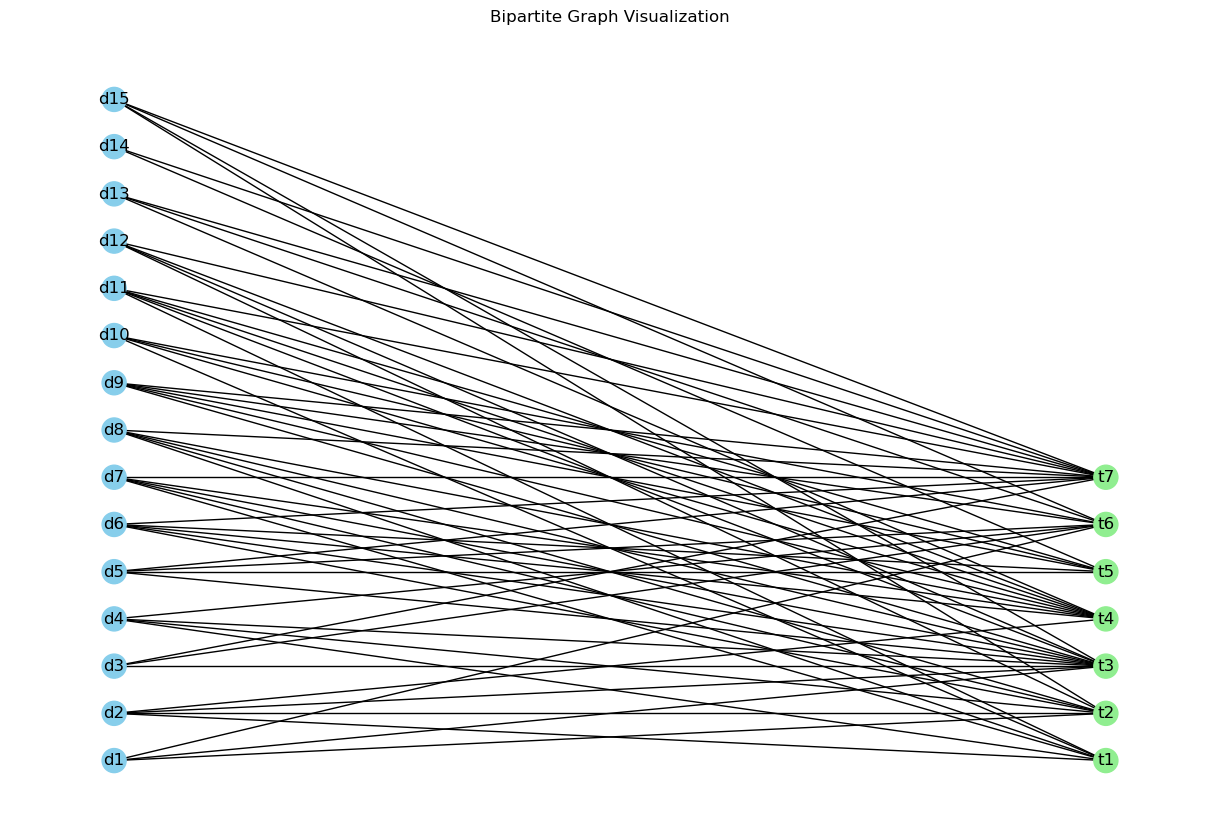

In [4]:
# Construct link prediction based on various methods, without using community 
# Input: Given a particular reaction class, determine the likelihood for a particular catalyst to be able to conduct that reaction through topology.

# Training-set: remove some edges
# Use link prediction algorithm to guess if there's a link
# compare link prediction algorithm and edges that were removed, use AUC to evaluate and get average AUC across all cross validation folds

# Define cluster for each group of d_nodes here:
clusters = {
    'c1': ['d1', 'd8', 'd3'],
    'c2': ['d4', 'd15'],
    'c3': ['d12', 'd7', 'd2', 'd9', 'd10'],
    'c4': ['d11', 'd6'],
    'c5': ['d13','d14','d5']
}
# Create a bipartite graph (Replace with bipartite graph from experiments)
B = nx.Graph()

# Add 15 nodes to the first partite set
d_nodes = [f'd{i}' for i in range(1, 16)]
B.add_nodes_from(d_nodes, bipartite=0)

# Add 7 nodes to the second partite set
t_nodes = [f't{i}' for i in range(1, 8)]
B.add_nodes_from(t_nodes, bipartite=1)

# Add edges between the two sets to form a complete bipartite graph
edges = [(d, t) for d in d_nodes for t in t_nodes]
B.add_edges_from(edges)

# Remove 30 random edges to create the missing links
random.seed(42)
edges_to_remove = random.sample(edges, 30)
B.remove_edges_from(edges_to_remove)

# Get the list of remaining edges
remaining_edges = list(B.edges())

# Get all possible pairs of d nodes and t nodes in the graph
all_pairs = list(itertools.product(d_nodes, t_nodes))

#Store number of d nodes, number of t nodes
num_d_nodes = len(d_nodes)
num_t_nodes = len(t_nodes)

# Identify number of missing edges from original graph:
# Get the pairs that have edges in training set graph
total_edges_set = set(B.edges())

print("Number of edges in this graph: ", len(total_edges_set))
print("Number of all possible edges in this graph: ", len(set(all_pairs)))

# Find pairs with no edges between them
original_no_edge_pairs = set(all_pairs) - total_edges_set
original_no_edge_pairs = list(original_no_edge_pairs)
    

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the edges into 5 folds
folds = list(kf.split(remaining_edges))

# Create 5-fold cross-validation sets
cv_sets = []
for train_index, test_index in folds:
    train_edges = [remaining_edges[i] for i in train_index]
    test_edges = [remaining_edges[i] for i in test_index]
    cv_sets.append((train_edges, test_edges))

# Create a list to store the new graphs
B_train_list = []

# Create a dictionary to store the test-edges for each graph 
dict_test_edges = {}

# Verify the cross-validation sets
for i, (train_edges, test_edges) in enumerate(cv_sets):
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")
    print(f"  Test set : {test_edges}")
    dict_test_edges[f'test_edge_{i}'] = test_edges

# Create new graphs for cross validation by removing test edges for each fold
for i, (train_edges, test_edges) in enumerate(cv_sets):
    B_train = B.copy()
    B_train.remove_edges_from(test_edges)
    B_train_list.append(B_train)

    # Print the sizes of the training and test sets
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")

# Verify the new graphs
for i, B_train in enumerate(B_train_list):
    print(f"B_train_{i+1} number of edges: {len(B_train.edges())}")

#Visualize one of the training set graphs
visualize_bipartite_graph(B_train_list[0], d_nodes, t_nodes)

# Dictionary to store DataFrames for each graph in each cross validation fold
df_dict_dt = {}   #store graph for both nodes
df_dict_cluster_dt = {} #store graph for cluster and t node
df_dict_merged_dt ={} #concated dataframe of both types of graphs

In [5]:
dict_test_edges['test_edge_0']

[('d1', 't1'),
 ('d1', 't7'),
 ('d2', 't6'),
 ('d3', 't2'),
 ('d3', 't5'),
 ('d4', 't4'),
 ('d6', 't6'),
 ('d7', 't5'),
 ('d7', 't6'),
 ('d9', 't1'),
 ('d10', 't3'),
 ('d12', 't6'),
 ('d13', 't1'),
 ('d13', 't2'),
 ('d14', 't6')]

In [6]:
# Iterate through every B in B_train_list
# Generate dataframe of 'test set' edges for every link prediction algorithm (neighbor/cluster based), assuming cluster is given
# Compare prediction trend of test set with the actual test set predictions

# Iterate each graph within training set
for idx, G in enumerate(B_train_list):
# for G in B_train_list:
    # Get the pairs that have edges in training set graph
    edges_set = set(G.edges())

    # print("Number of edges in this graph for training set: ", len(edges_set))
    # print("Number of all possible edges in this graph for training set: ", len(set(all_pairs)))
    # Find pairs with no edges between them
    training_no_edge_pairs = set(all_pairs) - edges_set
    training_no_edge_pairs = list(training_no_edge_pairs)

    # Ensure that the missing edges in each training set is equal to the sum of both the number of original missing edges and the additional ones from the test set
    assert len(training_no_edge_pairs) == len(original_no_edge_pairs) + len(test_edges)
    
    data = []
    # Calculate common neighbors and Jaccard coefficient for each pair without edges
    for d_node, t_node in training_no_edge_pairs:
        print('d_node: ', d_node, ' t_node: ', t_node)
        num_common_neighbor, jaccard_coefficient = common_neighbor_jaccard_coef(G, d_node, t_node)
        preferential_d_t = preferential_attachment(d_node,t_node)
        data.append({
            'd_node': d_node,
            't_node': t_node,
            'num_common_neighbor': num_common_neighbor,
            'jaccard_coefficient': jaccard_coefficient,
            'preferential_attach' : preferential_d_t
        })
    
    # Create the DataFrame of link prediction algorithm containing each d t pair that has missing edges, store into dctionary of dataframes
    df_neighbor = pd.DataFrame(data)
    df_dict_dt[f'graph_{idx}'] = df_neighbor
    print('Number of rows in node dataframe: ', df_dict_dt[f'graph_{idx}'].shape[0])

    # Step 3: Create a new graph connecting t_nodes to clusters
    H = nx.Graph()
    H_zero = nx.Graph() #Add a H_zero graph to store data for links where weight = 0 
    # Add t nodes to the new graph
    H.add_nodes_from(t_nodes, bipartite=1)
    H_zero.add_nodes_from(t_nodes, bipartite=1)
    # Add cluster nodes to the new graph
    H.add_nodes_from(clusters.keys(), bipartite=0)
    H_zero.add_nodes_from(clusters.keys(), bipartite=0)

    num_clusters = len(clusters)
    
    # Step 4: Calculate the weights for links between clusters and t_nodes
    # Initialize a dictionary to store weights for cluster-t_node links
    cluster_t_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}
    
    # Create list for links with zero weight
    cluster_t_zero_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}    
    
    # Iterate over the original edges and update the weights for the new graph
    for d, t in G.edges():
        for cluster, d_list in clusters.items():
            if d in d_list:
                cluster_t_weights[cluster][t] += 1
    
    # Add weighted edges to the new graph
    for cluster, t_weights in cluster_t_weights.items():
        for t, w in t_weights.items():
            if w > 0:  # Only add edges with non-zero weight
                H.add_edge(cluster, t, weight=w)    #Missing some t, cluster combinations since there is no link.
            elif w == 0:
                H_zero.add_edge(cluster, t, weight=w)
    
    # Print the new graph edges with weights
    print("Edges in the new graph with weights:")
    
    for (u, v, wt) in H.edges(data='weight'):
        print(f"({u}, {v}, {wt})")
        
    cluster_edge_weights_list = list(H.edges(data='weight'))  # list of weights for c-t edges
    cluster_edge_zero_weights_list = list(H_zero.edges(data='weight')) # list of missing links for c-t combinations

    #Make sure number of cluster x number of t nodes equal to the number of all possible edges between cluster and t nodes
    assert len(clusters) * num_t_nodes == len(cluster_edge_weights_list)+len(cluster_edge_zero_weights_list) 
    
    # Create a list to store the data
    data_cluster = []
    count = 0
    # Iterate through the clusters and their connections to t_nodes
    for t, c, weight in cluster_edge_weights_list:
        print(t,c, weight)
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(clusters[c]),
                                 weight/len(clusters[c]),
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))
    # Add the t_node cluster pair with no weights in to the dataframe as well, so we can get all 105 combinations of d and t
    for t, c, weight in cluster_edge_zero_weights_list:
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(clusters[c]),
                                 weight/len(clusters[c]),
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))
            
    # If t, cluster has no link, then we still need to record the d and t involved, where weight = 0, number of d in cluster is based on c
    # degree of cluster is equal to cluster, # jaccard coefficient is 0, degree_t is based on t preferential_attachment is calculated properly
    
    # Create the dataframe for cluster-t 
    cluster_df = pd.DataFrame(data_cluster, columns=['d_node', 
                                                     't_node', 
                                                     'common_neighbor_tc',
                                                     'number of d in cluster',
                                                     'jaccard_coeff_tc',
                                                     'degree_d_cluster',
                                                     'degree_t',
                                                     'preferential_attachment_cluster'])
    
    # print('Number of rows in cluster dataframe: ', cluster_df.shape[0])  #should have 105?

    # Make sure that the number of rows for the cluster dataframe is equal to the total possible combinations of all node connections
    assert cluster_df.shape[0] == len(set(all_pairs))

    # Create a DataFrame from training_no_edge_pairs
    training_no_edge_pairs_df = pd.DataFrame(training_no_edge_pairs, columns=['d_node', 't_node'])
    print('Number of rows in no edge pair dataframe: ', training_no_edge_pairs_df.shape[0])
    
    # Merge the cluster_df with training_no_edge_pairs_df on d_node and t_node
    filtered_cluster_df = pd.merge(cluster_df, training_no_edge_pairs_df, on=['d_node', 't_node'])
    
    # Store dataframe into a dictionary of dataframes
    df_dict_cluster_dt[f'graph_{idx}'] = filtered_cluster_df

    df_dict_merged_dt[f'graph_{idx}'] = pd.merge(df_dict_dt[f'graph_{idx}'], df_dict_cluster_dt[f'graph_{idx}'], on=['d_node', 't_node'], how='inner')
    # print('Number of rows in merged dataframe: ', df_dict_merged_dt[f'graph_{idx}'].shape[0])

    # Make sure that the number of rows after merging is equal to the number of missing pairs from the training graph 
    assert df_dict_merged_dt[f'graph_{idx}'].shape[0] == len(training_no_edge_pairs)

# Check graph_0 within both dictionary
# print('Dataframe_neighbors: ',df_dict_dt['graph_0'])
# print('Dataframe_clusters: ',df_dict_cluster_dt['graph_0'])  
# print('Merged dataframe: ',df_dict_merged_dt['graph_0']) 
column_list = df_dict_merged_dt['graph_0'].columns.tolist() 
print(column_list)
        

d_node:  d13  t_node:  t1
Jaccard_coefficient: 1.0
d_node:  d5  t_node:  t4
Jaccard_coefficient: 1.0
d_node:  d6  t_node:  t1
Jaccard_coefficient: 1.0
d_node:  d15  t_node:  t1
Jaccard_coefficient: 1.0
d_node:  d12  t_node:  t6
Jaccard_coefficient: 1.0
d_node:  d1  t_node:  t5
Jaccard_coefficient: 0.8888888888888888
d_node:  d14  t_node:  t2
Jaccard_coefficient: 0.7
d_node:  d12  t_node:  t1
Jaccard_coefficient: 1.0
d_node:  d14  t_node:  t3
Jaccard_coefficient: 0.7857142857142857
d_node:  d1  t_node:  t4
Jaccard_coefficient: 1.0
d_node:  d14  t_node:  t6
Jaccard_coefficient: 0.8
d_node:  d8  t_node:  t5
Jaccard_coefficient: 1.0
d_node:  d4  t_node:  t5
Jaccard_coefficient: 0.9
d_node:  d5  t_node:  t2
Jaccard_coefficient: 1.0
d_node:  d10  t_node:  t7
Jaccard_coefficient: 1.0
d_node:  d14  t_node:  t1
Jaccard_coefficient: 0.75
d_node:  d3  t_node:  t5
Jaccard_coefficient: 1.0
d_node:  d7  t_node:  t5
Jaccard_coefficient: 1.0
d_node:  d10  t_node:  t2
Jaccard_coefficient: 1.0
d_node:  

NameError: name 'count' is not defined

In [ ]:
df_dict_dt['graph_0'].to_csv('dataframe_neighbors.csv', index=False)

In [29]:
# Evaluate Precision & AUPR for each cross validation by using the test set established earlier:
# Iterate through each dataframe. For each dataframe, obtain rows with test set node pairs only (which should all be 1) normalize prediction scores, 
# Generate Precision & AUPR for that dataframe for each link prediction algorithm
# Then obtain average AUC and AUPR for all dataframe to reach link prediction algorithm 
# References for understanding link prediction evaluation metrics:
# Simone Daminelli et al 2015 New J. Phys. 17 113037 Main journal used for adopting precision & aupr over auc
# Yang, Y., Lichtenwalter, R.N. & Chawla, N.V. Evaluating link prediction methods. Knowl Inf Syst 45, 751–782 (2015). States that ROC is deceptive. 

score_column = ['num_common_neighbor', 
                'jaccard_coefficient', 
                'preferential_attach', 
                'common_neighbor_tc', 
                'jaccard_coeff_tc', 
                'preferential_attachment_cluster']

all_results = []
for idx in range(5):
    df_merge = df_dict_merged_dt[f'graph_{idx}'] # Get all missing edges from the training set graph
    # Normalize each column
    for column in score_column:
        min_value = df_merge[column].min()
        max_value = df_merge[column].max()
        df_merge[column] = (df_merge[column] - min_value) / (max_value - min_value)

    #print('df_merge_normalized: ', df_merge)
    test_edges_set = set(dict_test_edges[f'test_edge_{idx}']) # Used to identify the test_edges
    l = len(test_edges_set)    
    print('List of test edges:', test_edges_set)
    
    # Create a new column in df_merge called 'actual outcome'
    # For d node and t nodes that are within the list_test_edges, put 1 in the acutal outcome
    # For the rest of the nodes, put 0
    df_merge['actual outcome'] = df_merge.apply(lambda row: 1 if (row['d_node'], row['t_node']) in test_edges_set else 0, axis=1)
    print(df_merge)


    # Iterate through each prediction algorithm and calculate the metrics (precieion and aupr)
    results = []
    for score_type in score_column:
        precision_at_L, aupr = calculate_metric(df_merge, score_type, l)
        results.append({'Link Prediction Algorithm': score_type, 'Precision': precision_at_L, 'AUPR': aupr})
        
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Append to all results
    all_results.append(results_df)
    
    # Display the results
    print(results_df)


# Concatenate all results DataFrames into a single DataFrame
concatenated_results = pd.concat(all_results)

# Group by algorithm and calculate the mean of precision_at_L and aupr
average_results = concatenated_results.groupby('Link Prediction Algorithm').mean().reset_index()
    # Iterate through each prediction algorithm, by creating a dataframe where we have the d_node, t_node, prediction algorithm, and actual outcome
    # sort rows based on the normalized score under the prediction algorithm
    # Obtain precision value by analyzing how many 1s are there in the top L rows out of L rows
    # Obtain AUPR with both column
# Display the average results
print('Average results: ', average_results)


List of test edges: {('d9', 't1'), ('d1', 't7'), ('d10', 't3'), ('d6', 't6'), ('d7', 't6'), ('d14', 't6'), ('d13', 't1'), ('d3', 't5'), ('d7', 't5'), ('d4', 't4'), ('d1', 't1'), ('d3', 't2'), ('d12', 't6'), ('d2', 't6'), ('d13', 't2')}
   d_node t_node  num_common_neighbor  jaccard_coefficient  \
0     d12     t5                  0.4             1.000000   
1      d1     t7                  0.7             0.761905   
2     d14     t4                  0.4             0.696970   
3      d6     t6                  0.7             1.000000   
4     d15     t5                  0.4             1.000000   
5     d14     t6                  0.2             0.333333   
6     d13     t1                  0.3             1.000000   
7      d7     t5                  0.5             1.000000   
8      d1     t1                  0.3             1.000000   
9     d12     t6                  0.6             1.000000   
10     d2     t5                  0.3             0.666667   
11     d4     t5    

In [30]:
average_results

,Link Prediction Algorithm,Precision,AUPR
0,common_neighbor_tc,0.413333,0.463847
1,jaccard_coeff_tc,0.413333,0.466849
2,jaccard_coefficient,0.253333,0.565836
3,num_common_neighbor,0.373333,0.405834
4,preferential_attach,0.333333,0.358667
5,preferential_attachment_cluster,0.346667,0.458117
